In [15]:
from parser import get_files_in_folder, parse_gene_sequences
from damerau_levenshtein import damerau_levenshtein
from gen_algo import crossover, mutate

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import os, sys

In [17]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from sklearn.cluster import KMeans, HDBSCAN, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.model_selection import ParameterGrid
from keras.utils import to_categorical

In [100]:
dataset = pd.read_csv('dataset copy.csv', sep=';')

x = dataset.iloc[:, 1:].values
y = dataset.iloc[:, 0].values

In [101]:
pca = PCA(n_components=0.95, random_state=42)
x_pca = pca.fit_transform(x)

scaler = StandardScaler()
x_scaled = scaler.fit_transform(x_pca)

In [102]:
# implementing silhoutte score
params = [2, 3, 4, 5, 6, 7, 8, 9, 10]
paramGrid = ParameterGrid({'n_clusters': params})

best_score = -1

silhouette_scores = []

kmeans = KMeans()

for p in paramGrid:
	kmeans.set_params(**p)
	kmeans.fit(x_pca)

	silScore = silhouette_score(x_pca, kmeans.labels_, random_state=0)
	silhouette_scores.append(silScore)

	print('Parameter: ', p, 'Score: ', silScore)

	if silScore > best_score:
		best_score = silScore
		best_grid = p

Parameter:  {'n_clusters': 2} Score:  0.7886130602910515
Parameter:  {'n_clusters': 3} Score:  0.8278973495084748
Parameter:  {'n_clusters': 4} Score:  0.9300099038190928
Parameter:  {'n_clusters': 5} Score:  0.8707557687537142
Parameter:  {'n_clusters': 6} Score:  0.8700979707653411
Parameter:  {'n_clusters': 7} Score:  0.9526885350287364
Parameter:  {'n_clusters': 8} Score:  0.952688588016981
Parameter:  {'n_clusters': 9} Score:  0.9542848751742277
Parameter:  {'n_clusters': 10} Score:  0.95797424589981


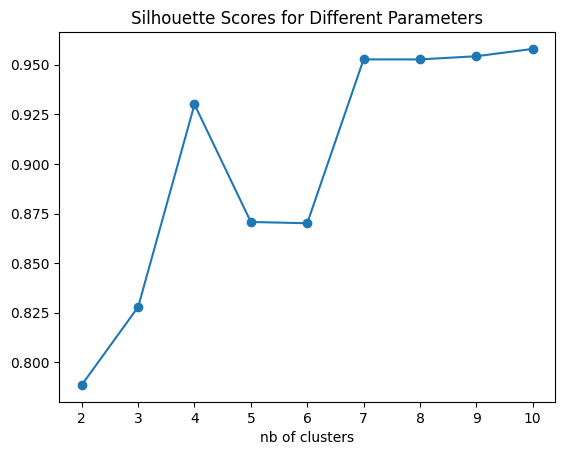

In [103]:
# plot the silhouette scores
plt.plot(range(len(silhouette_scores)), silhouette_scores, marker='o')
plt.xticks(range(len(silhouette_scores)), params)
plt.title('Silhouette Scores for Different Parameters')
plt.xlabel('nb of clusters')

plt.show()

Best grid:  10 Best score:  0.95797424589981


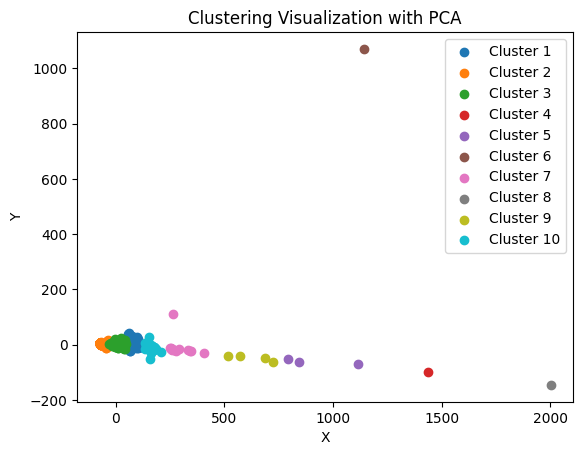

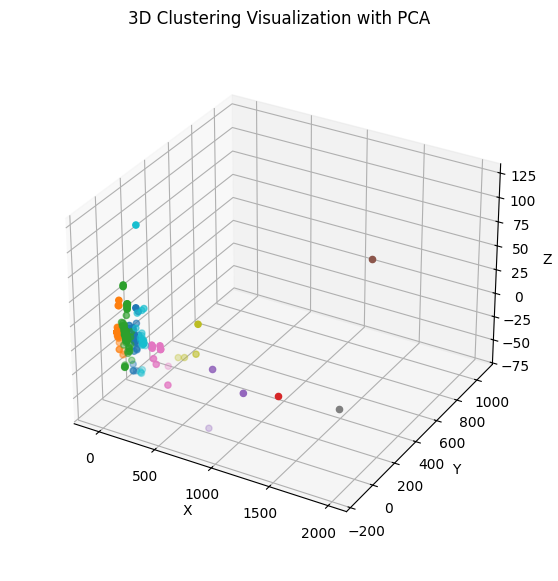

In [104]:
print('Best grid: ', best_grid['n_clusters'], 'Best score: ', best_score)

y_pred = KMeans(n_clusters=best_grid['n_clusters'], random_state=42).fit_predict(x_pca)

km = KMeans(n_clusters=best_grid['n_clusters'], random_state=42).fit(x_pca)
y_kmeans = km.predict(x_pca)

# plt.scatter(x_pca[:, 0], x_pca[:, 1], c=kmeans.labels_)

# legend
for i in range(best_grid['n_clusters']):
	plt.scatter(
		x_pca[y_kmeans == i, 0],
		x_pca[y_kmeans == i, 1], 
		label=f'Cluster {i+1}')
	
plt.legend()

plt.title('Clustering Visualization with PCA')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

# 3D plot
from mpl_toolkits.mplot3d import Axes3D

x_pca_3d = PCA(n_components=3, random_state=42).fit_transform(x)

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')
# ax.view_init(azim=270,elev=90)
# ax.scatter(x_pca_3d[:, 0], x_pca_3d[:, 1], x_pca_3d[:, 2], c=kmeans.labels_)
# legend
for i in range(best_grid['n_clusters']):
	ax.scatter(
		x_pca_3d[y_kmeans == i, 0],
		x_pca_3d[y_kmeans == i, 1], 
		x_pca_3d[y_kmeans == i, 2], 
		label=f'Cluster {i}')

ax.set_title('3D Clustering Visualization with PCA')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.set_box_aspect(None, zoom=0.9)

plt.show()

In [116]:
db = DBSCAN(eps=1, min_samples=5)
db.fit(x)
db_labels = db.labels_

hdb = HDBSCAN(min_cluster_size=5, 
			  min_samples=1, 
			  cluster_selection_epsilon=1,
			  allow_single_cluster=True)
hdb.fit(x)
hdb_labels = hdb.labels_

Max number of clusters found by DBSCAN:  15


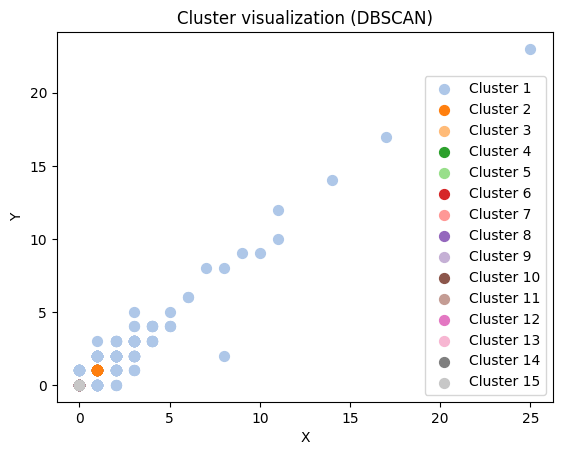

Max number of clusters found by HDBSCAN:  27


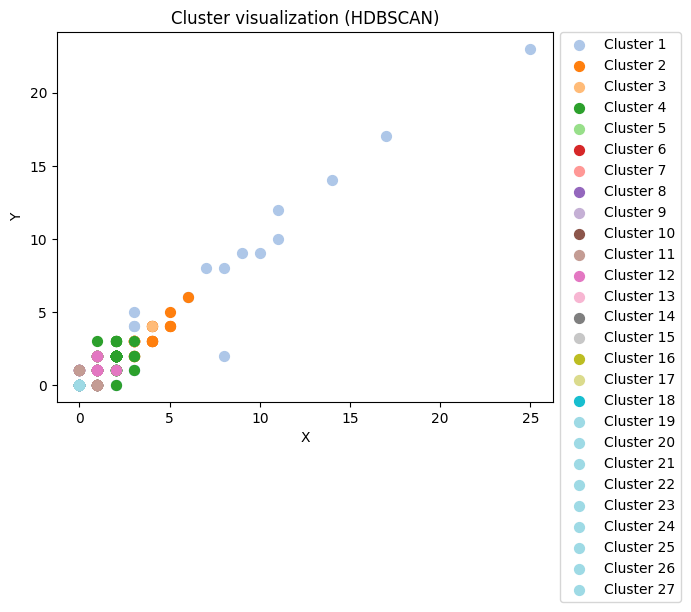

In [133]:
# print max number of clusters found by HDBSCAN
print('Max number of clusters found by DBSCAN: ', len(np.unique(db_labels)))

for i in np.unique(db_labels):
	plt.scatter(x[db_labels == i, 0], x[db_labels == i, 1], s=50, label='Cluster ' + str(i+2), color=plt.cm.tab20(i+2))

plt.title('Cluster visualization (DBSCAN)')
plt.xlabel('X')
plt.ylabel('Y')

plt.legend()
plt.show()

# print max number of clusters found by HDBSCAN
print('Max number of clusters found by HDBSCAN: ', len(np.unique(hdb_labels)))

for i in np.unique(hdb_labels):
	plt.scatter(x[hdb_labels == i, 0], x[hdb_labels == i, 1], s=50, label='Cluster ' + str(i+2), color=plt.cm.tab20(i+2))

plt.title('Cluster visualization (HDBSCAN)')
plt.xlabel('X')
plt.ylabel('Y')

plt.legend(bbox_to_anchor=(1, 1.018), loc='upper left')
plt.show()

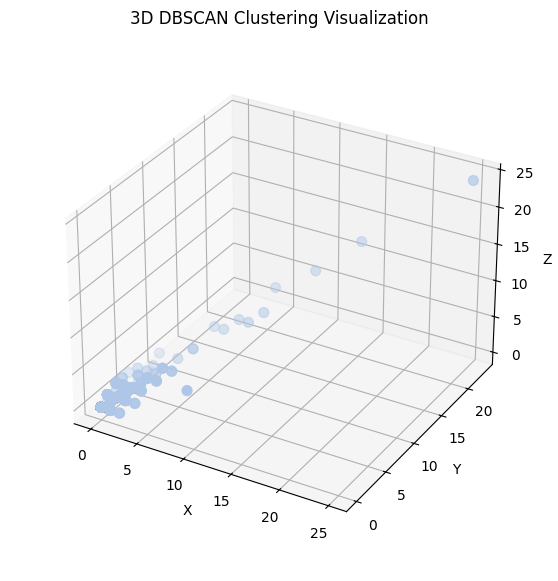

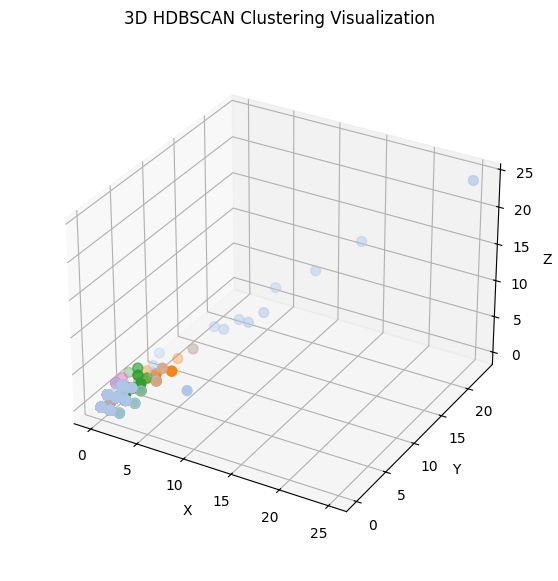

In [121]:
# 3D plot of HDBSCAN clusters
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')

x_3d = x

# ax.view_init(azim=240)
for i in np.unique(db_labels):
	ax.scatter(
		x_3d[db_labels == i, 0],
		x_3d[db_labels == i, 1], 
		x_3d[db_labels == i, 2], 
		s=50, label='Cluster ' + str(i+1),
  		color=plt.cm.tab20(i+2))
 
ax.set_title('3D DBSCAN Clustering Visualization')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.set_box_aspect(None, zoom=0.9)

# plt.legend()

plt.show()

# 3D plot of HDBSCAN clusters
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')

x_3d = x

# ax.view_init(azim=240)
for i in np.unique(hdb_labels):
	ax.scatter(
		x_3d[hdb_labels == i, 0],
		x_3d[hdb_labels == i, 1], 
		x_3d[hdb_labels == i, 2], 
		s=50, label='Cluster ' + str(i+1),
  		color=plt.cm.tab20(i+2))
 
ax.set_title('3D HDBSCAN Clustering Visualization')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.set_box_aspect(None, zoom=0.9)

# plt.legend()

plt.show()

c:\Users\theof\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 64)             │       451,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 7057)           │       458,705 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 915,681 (3.49 MB)

 Trainable params: 915,681 (3.49 MB)

 Non-trainable params: 0 (0.00 B)

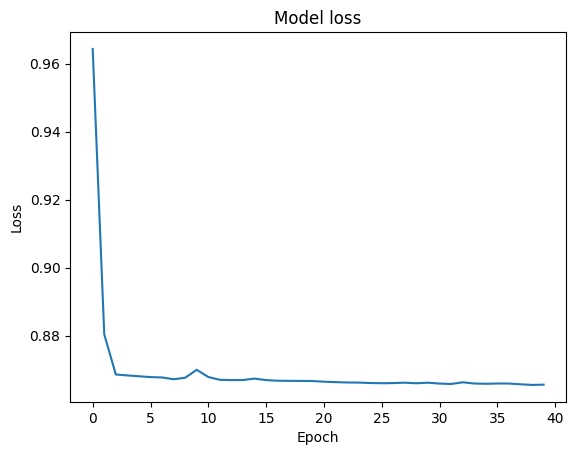

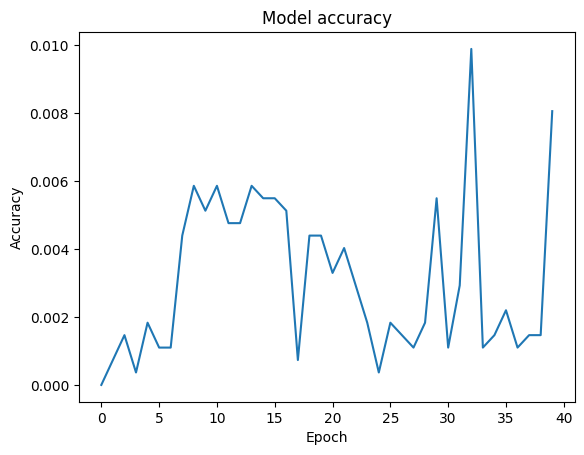

In [144]:
# Définir un modèle autoencodeur pour le clustering
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(x.shape[1],)))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(x.shape[1], activation='sigmoid'))

# Compiler le modèle avec une fonction de perte adaptée
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

# Afficher le résumé du modèle
model.summary()
                                                                       
# Entraînement du modèle (Autoencodeur)
history = model.fit(x, x, epochs=40, batch_size=32, verbose=0)

# Afficher l'évolution de la fonction de perte
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.show()

# Afficher l'évolution de la précision
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.show()

In [153]:
# clustering
encoder = Sequential()
encoder.add(model.layers[0])
encoder.add(model.layers[1])
encoder.add(model.layers[2])

X_encoded = encoder.predict(x)

# decoder = Sequential()
decoder = Sequential()
decoder.add(model.layers[3])
decoder.add(model.layers[4])
decoder.add(model.layers[5])
X_decoded = decoder.predict(X_encoded)

# print max number of clusters found by encoder
print('Max number of clusters found by encoder: ', len(np.unique(y_pred)))

86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Max number of clusters found by encoder:  9


Parameter:  {'n_clusters': 6} Score:  0.9906609058380127
Parameter:  {'n_clusters': 7} Score:  0.9912872910499573
Parameter:  {'n_clusters': 8} Score:  0.9921389222145081
Parameter:  {'n_clusters': 9} Score:  0.9914630055427551
Parameter:  {'n_clusters': 10} Score:  0.9926320314407349
Parameter:  {'n_clusters': 12} Score:  0.9912917017936707
Parameter:  {'n_clusters': 14} Score:  0.9914368391036987
Parameter:  {'n_clusters': 16} Score:  0.9912580847740173


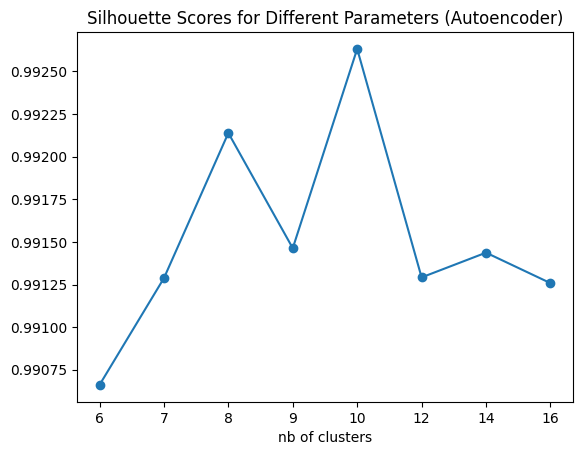

Best grid:  10 Best score:  0.9926320314407349


In [165]:
# implementing silhoutte score
params_encoded = [6, 7, 8, 9, 10, 12, 14, 16]
paramGrid_encoded = ParameterGrid({'n_clusters': params_encoded})

best_score_encoded = -1

silhouette_scores_encoded = []

kmeans_encoded = KMeans()

for p_encoded in paramGrid_encoded:
	kmeans_encoded.set_params(**p_encoded)
	kmeans_encoded.fit(X_decoded)

	silScore_encoded = silhouette_score(X_decoded, kmeans_encoded.labels_, random_state=0)
	silhouette_scores_encoded.append(silScore_encoded)

	print('Parameter: ', p_encoded, 'Score: ', silScore_encoded)

	if silScore_encoded > best_score_encoded:
		best_score_encoded = silScore_encoded
		best_grid_encoded = p_encoded

# plot the silhouette scores
plt.plot(range(len(silhouette_scores_encoded)), silhouette_scores_encoded, marker='o')
plt.xticks(range(len(silhouette_scores_encoded)), params_encoded[:len(silhouette_scores_encoded)])
plt.title('Silhouette Scores for Different Parameters (Autoencoder)')
plt.xlabel('nb of clusters')
plt.show()
print('Best grid: ', best_grid_encoded['n_clusters'], 'Best score: ', best_score_encoded)

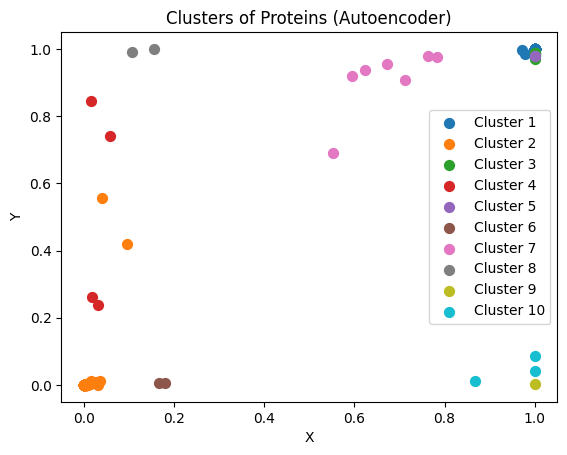

In [168]:
# clustering
kmeans = KMeans(n_clusters=10, random_state=0)
y_pred = kmeans.fit_predict(X_decoded)

# ax = plt.gca()
# ax.set_xlim([-5, 50])
# ax.set_ylim([-5, 30])

# Afficher les résultats du clustering
for i in range(10):
	plt.scatter(X_decoded[y_pred == i, 0], X_decoded[y_pred == i, 1], s=50, label='Cluster ' + str(i+1))

plt.title('Clusters of Proteins (Autoencoder)')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()

plt.show()

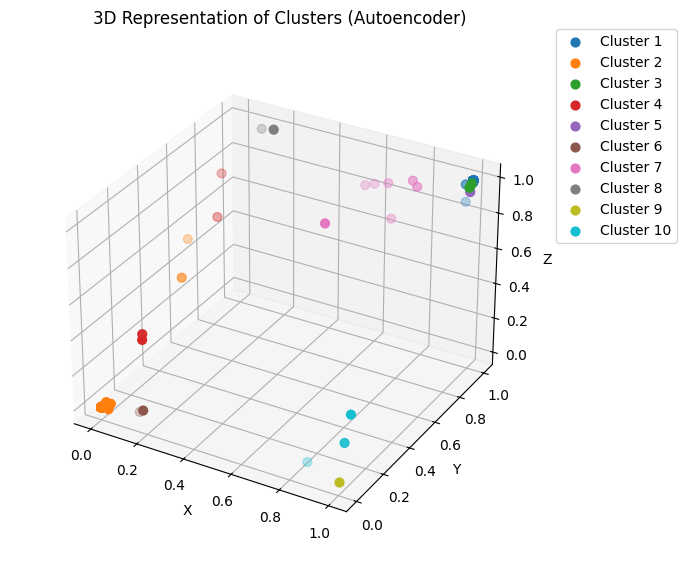

In [169]:
from mpl_toolkits.mplot3d import Axes3D

pca_3d = PCA(n_components=3)
X_encoded_3d = X_decoded

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')

for i in np.unique(y_pred):
	ax.scatter(
		X_encoded_3d[y_pred == i, 0],
		X_encoded_3d[y_pred == i, 1],
		X_encoded_3d[y_pred == i, 2],
		s=40,
		label=f'Cluster {i+1}'
	)

ax.set_title('3D Representation of Clusters (Autoencoder)')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend(bbox_to_anchor=(1, 1.018), loc='upper left')
ax.set_box_aspect(None, zoom=0.9)
plt.show()